# Workflow

## Setup

Setup magic autoreload

In [1]:
%load_ext autoreload
%autoreload 2

Setup logging

In [2]:
import logging
from pathlib import Path
from IPython.display import Image, display, Markdown
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# In case of debugging, set the level to logging.DEBUG

Ensure that you have already configured your environment variable following the instructions in the [README](../README.md)

In [3]:
import os
assert os.getenv('LLM_DSL_CONFIG_PATH') is not None, "Please set the LLM_DSL_CONFIG_PATH environment variable to the path of the config file"
assert os.getenv('LLM_DSL_API_PATH') is not None, "Please set the LLM_DSL_CONFIG_PATH environment variable to the path of the config file"

# 1. First glance

2025-02-06 01:12:03,365 - dsl_gen - INFO - Configuration initialized


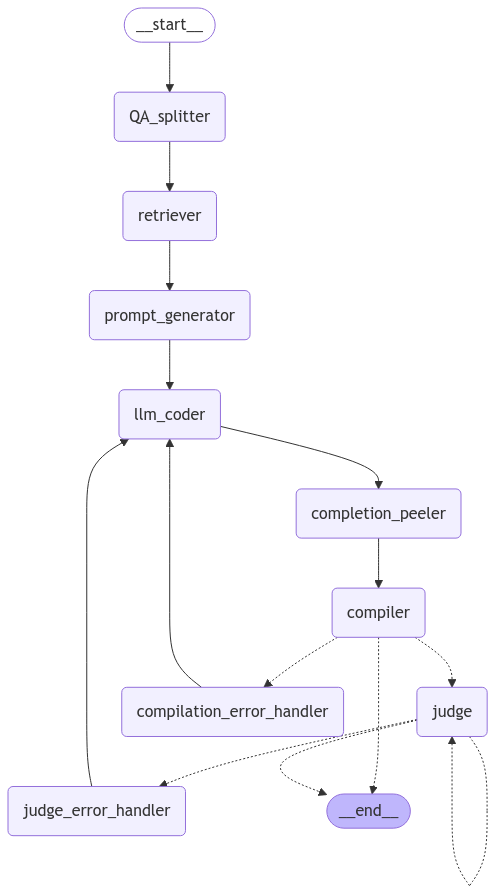

In [4]:
from dsl_gen.core.flows import build_rag_flow
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
flow = build_rag_flow()
flow.get_graph()
display(
    Image(
        flow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

```mermaid
flowchart TD
    __start__(["<p>__start__</p>"]) --> QA_splitter("QA_splitter")
    QA_splitter --> retriever("retriever")
    judge_error_handler --> llm_coder
    compilation_error_handler --> llm_coder
    retriever --> prompt_generator("prompt_generator")
    prompt_generator --> llm_coder("llm_coder")
    llm_coder --> completion_peeler("completion_peeler")
    completion_peeler --> compiler("compiler")

    
    judge("judge") -.-> judge_error_handler("judge_error_handler") & __end__
    compiler -.-> judge & compilation_error_handler("compilation_error_handler")　& __end__
    

     __start__:::first
     __end__:::last
    classDef default fill:#f2f0ff,stroke:#888,stroke-width:1px,line-height:1.2
    classDef first fill-opacity:0,stroke-width:0
    classDef last fill:#bfb6fc,stroke:#888,stroke-width:1px
```

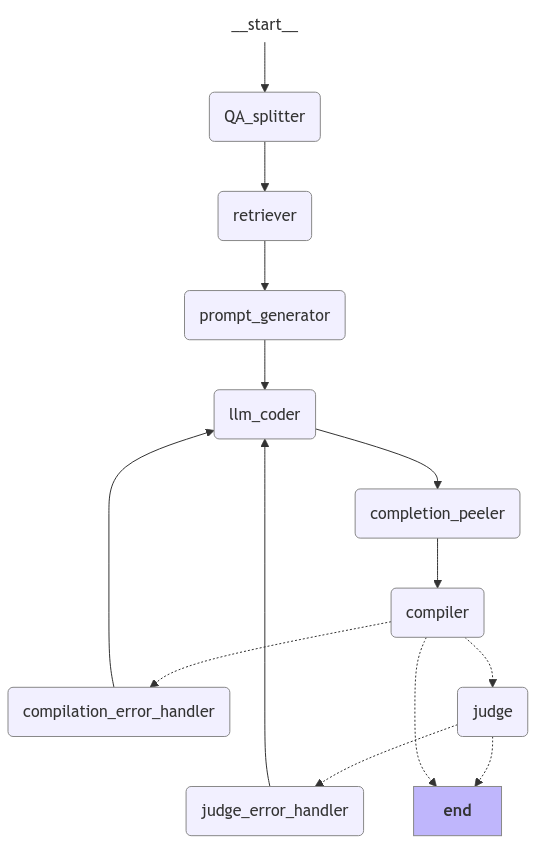

In [5]:
from langchain_core.runnables.graph_mermaid import _render_mermaid_using_api
from PIL import Image
import io

mermaid_graph = """
flowchart TD
    __start__(["<p>__start__</p>"]) --> QA_splitter("QA_splitter")
    QA_splitter --> retriever("retriever")
    judge_error_handler --> llm_coder
    compilation_error_handler --> llm_coder
    retriever --> prompt_generator("prompt_generator")
    prompt_generator --> llm_coder("llm_coder")
    llm_coder --> completion_peeler("completion_peeler")
    completion_peeler --> compiler("compiler")

    
    judge("judge") -.-> judge_error_handler("judge_error_handler") & __end__
    compiler -.-> judge & compilation_error_handler("compilation_error_handler")　& __end__
    

     __start__:::first
     __end__:::last
    classDef default fill:#f2f0ff,stroke:#888,stroke-width:1px,line-height:1.2
    classDef first fill-opacity:0,stroke-width:0
    classDef last fill:#bfb6fc,stroke:#888,stroke-width:1px
"""

Image.open(io.BytesIO(_render_mermaid_using_api(mermaid_graph)))

## How to use

In [6]:
from dsl_gen import CFG

# Set the logging level to DEBUG to see the entire flow
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('dsl_gen')
logger.setLevel(logging.DEBUG)

# Customize the configuration by directly modifying the CFG!
CFG.PRETTY_PRINT = False # Set to True to enable pretty print
CFG.CODER.active_model = 'openai' # 'openai', 'deepseek' or 'ollama'
CFG.JUDGE.active_model = 'openai'


In [7]:
query = 'Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.'

result = flow.invoke({"question": query, "question_type": "coding"})

display(Markdown(f"```envision\n{result['completion']}```"))

2025-02-06 01:12:12,122 - dsl_gen - DEBUG - QA Splitter: question provided, eval mode
2025-02-06 01:12:12,123 - dsl_gen - DEBUG - Retrieving docs for query: Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.


**Question**
Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.


2025-02-06 01:12:13,742 - dsl_gen - INFO - Setting seed: 114514
2025-02-06 01:12:13,743 - dsl_gen - INFO - Loading embedding model into RAM: hf/sentence-transformers/all-mpnet-base-v2
2025-02-06 01:12:16,666 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2025-02-06 01:12:18,467 - dsl_gen - INFO - Loading cached vectorstore from D:/Projects/PSC/LLM-DSL-Gen/vector_db\vectorstore_hf_sentence-transformers_all-mpnet-base-v2
2025-02-06 01:12:18,469 - faiss.loader - INFO - Loading faiss with AVX2 support.
2025-02-06 01:12:18,581 - faiss.loader - INFO - Successfully loaded faiss with AVX2 support.
2025-02-06 01:12:18,587 - faiss - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.
2025-02-06 01:12:18,752 - dsl_gen - INFO - Retrieved 20 docs
2025-02-06 01:12:18,756 - dsl_gen - DEBUG - Generated prompt: [SystemMessage(content='You are a proficien

**Coder's Completion**
greetings = "Hello"
show label greetings


2025-02-06 01:12:20,077 - dsl_gen - DEBUG - Compilation successful
2025-02-06 01:12:20,079 - dsl_gen - INFO - Code compiled successfully (Attempt 1)
2025-02-06 01:12:26,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-06 01:12:26,642 - dsl_gen - INFO - Judgment: Based on the provided problem statement and answer:

### Stepwise Verification:
1. **Logical Completeness**:
   - The solution defines the text literal `greetings` with the value "Hello".
   - It displays the `greetings` on the dashboard as a label.
   - The solution implements all required components of the problem statement.

2. **Logical Consistency**:
   - The data flow is self-consistent.
   - There are no contradictory conditionals.
   - The solution is logically consistent.

3. **Verifiability**:
   - The critical computation steps are traceable.
   - Key parameters like `greetings` are configurable.

### Final Judgment:
Considering the evaluation criteria and s

```envision
greetings = "Hello"
show label greetings```

Or you can simply pass a string as the question for the workflow.

In [8]:
challenge_path = Path(CFG.PATH_CFG.CHALLENGES_PATH) / "c000.json"

result = flow.invoke({"challenge_path": str(challenge_path)}) 

display(Markdown(f"```envision\n{result['completion']}```"))

2025-02-06 01:12:29,153 - dsl_gen - DEBUG - QA Splitter: challenge path provided, path=D:\Projects\PSC\LLM-DSL-Gen\benchmarks\challenges\c000.json
2025-02-06 01:12:29,154 - dsl_gen - DEBUG - Retrieving docs for query: Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.
2025-02-06 01:12:29,215 - dsl_gen - INFO - Retrieved 20 docs
2025-02-06 01:12:29,217 - dsl_gen - DEBUG - Generated prompt: [SystemMessage(content='You are a proficient coder in a Domain Specific Language called Envision. Your task is to generate response to the given challenge. Some challenges will ask you to generate Envision code,others will ask you to explain given code or answer questions related to the Envision language. Do not output any intermediate thinking or explanation, only give the final answer.', additional_kwargs={}, response_metadata={}), SystemMessage(content='Relevant Context:\nDocument 1 (from D:/Projects/PSC/LLM-DSL-Gen/docs\\_index.md):\n## Hel

**Question**
Define a text literal called greetings with value "Hello" and display greetings on the dashboard as a label.


2025-02-06 01:12:29,821 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-06 01:12:29,826 - dsl_gen - DEBUG - Model's response:
 ```envision
greetings = "Hello"
show label greetings
```

2025-02-06 01:12:29,828 - dsl_gen - DEBUG - Completion Peeler: received coder's completion content='```envision\ngreetings = "Hello"\nshow label greetings\n```' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 5319, 'total_tokens': 5335, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-b1d93004-c981-40ea-9a72-cfc429286a32-0' usage_metadata={'input_tokens': 5319, 'output_tokens': 16, 'total_tokens': 5335, 'input_token_d

**Coder's Completion**
greetings = "Hello"
show label greetings


2025-02-06 01:12:30,150 - dsl_gen - DEBUG - Compilation successful
2025-02-06 01:12:30,152 - dsl_gen - INFO - Code compiled successfully (Attempt 1)
2025-02-06 01:12:32,183 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-06 01:12:32,195 - dsl_gen - INFO - Judgment: **Step 1: Logical Completeness**
- The solution defines the text literal "Hello" as `greetings`.
- The solution then displays `greetings` as a label.

**Step 2: Logical Consistency**
- The data flow is self-consistent. The text literal `greetings` is defined and then displayed correctly without any contradictions.

**Step 3: Verifiability**
- Critical steps like defining the text literal and displaying it as a label can be traced clearly.
- Key parameter, `greetings`, is configurable and utilized correctly in the display step.

Based on the evaluation against the provided checklist and reference solution, the solution is logically sound with no flaws.

**Final Judgment

```envision
greetings = "Hello"
show label greetings```

# 2. Components

## VectorDB

Uncomment the following line to build vectorstore manually.

In [3]:
# from dsl_gen.core.vector_store import _build_vectorstore
# store = _build_vectorstore()

### Visualize a question

Before building vectorstore, we can visualize a question to understand the data.

In [ ]:
from IPython.display import Markdown


display(Markdown(query))
answer = '```envision\ngreetings = "Hello" // define the text literal\nshow label greetings // show the text literal as a label. There should be no \'with\' !\n```'
display(Markdown(answer))

## Build vectorstore

In [ ]:
from dsl_gen.core.vector_store import get_vectorstore
from dsl_gen.config import CFG

# It is normal that you see INFO - Failed to load GPU Faiss
# Since we are using CPU Faiss
vectorstore = get_vectorstore()

<span style="color:green;"><b>It is normal that you see the message</b></span> `Failed to load GPU Faiss` <span style="color:green;"><b>since we are using</b></span> `Faiss-CPU`.

Let's see how to retrieve docs by their indices

In [ ]:
from IPython.display import Markdown
doc_ids = list(vectorstore.index_to_docstore_id.values())[:5]
for doc_id in doc_ids:
    document = vectorstore.docstore.search(doc_id)
    display(Markdown(document.page_content))

In [ ]:
doc_ids = list(vectorstore.index_to_docstore_id.values())[50:53]

display(Markdown('### Displaying documents 50, 51, 52'))

for doc_id in doc_ids:
    document = vectorstore.docstore.search(doc_id)
    
    display(Markdown(document.page_content))

## Similarity search

In [9]:
vectorstore = get_vectorstore()

In [ ]:
query="Define a text literal called greetings with value \"Hello\" and display greetings on the dashboard as a label."
documents = vectorstore.similarity_search(k = 3, query=query)
document

In [ ]:
for idx, doc in enumerate(documents):
    display(Markdown(f"### Document {idx} \n {doc.page_content}"))
display(Markdown('---'))

## Try queries with a few questions

In [ ]:
from dsl_gen.core.vector_store import get_vectorstore
from dsl_gen.config import CFG
from pathlib import Path
import json

vectorstore = get_vectorstore()

file_path = Path(CFG.PATH_CFG.CHALLENGES_PATH) / "c001.json"

with open(file_path, 'r') as f:
    data = json.load(f)

question = data['question']

print(question)

In [ ]:
documents = vectorstore.similarity_search(k = 20, query=question)
document

In [ ]:
for idx, doc in enumerate(documents):
    print(f"Document {idx}")
    print(doc.page_content)
    print('\n')

# Test RAG flow

## Visualize workflow

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

from dsl_gen.core.flows import build_rag_flow

flow = build_rag_flow()
display(
    Image(
        flow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
print(flow.get_graph().draw_mermaid())

---

## Invoke workflow

In [ ]:
from dsl_gen import CFG
from pathlib import Path
from dsl_gen.core.flows import build_rag_flow
import logging
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# Reset the active model to openai to boost inference speed
CFG.MODEL_CFG.active_model = "openai"

challenge_path = Path(CFG.PATH_CFG.CHALLENGES_PATH) / "c001.json" 

flow = build_rag_flow()

# It is normal that you see 'INFO - Failed to load GPU Faiss'
# since we are using CPU
result = flow.invoke({"challenge_path": str(challenge_path)}) 

print(result["completion"]) 

---

# Appendix: VectorStore

Below is a detailed explanation of VectorStore content display and similarity search filters:

---

## How to View Chunk Content in VectorStore

### Method 1: Directly Accessing the Underlying Storage (Using FAISS as an Example)

```python
# Assuming an initialized vectorstore object

from langchain_community.vectorstores import FAISS

def show_all_chunks(vectorstore: FAISS) -> list:
    """Displays all stored chunks and their metadata"""
    chunks = []
    # Iterate through all document IDs
    for doc_id in vectorstore.index_to_docstore_id.values():
        document = vectorstore.docstore.search(doc_id)
        chunks.append({
            "id": doc_id,
            "content": document.page_content,
            "metadata": document.metadata
        })
    return chunks

# Example usage
for chunk in show_all_chunks(vectorstore):
    print(f"[ID: {chunk['id']}]")
    print(f"Metadata: {chunk['metadata']}")
    print(f"Content: {chunk['content'][:50]}...\n")

# Sample Output:
# [ID: 89a3b2f1]
# Metadata: {'source': 'manual.pdf', 'page': 23}
# Content: Envision language supports time series analysis using window functions...
```

### Method 2: Retrieve All Chunks via Search (Temporary Approach)
```python
# Retrieve all documents by searching an empty string (Use with caution)
all_docs = vectorstore.similarity_search(query="", k=1000)  # Set k to a sufficiently large number
for i, doc in enumerate(all_docs):
    print(f"Chunk {i+1}: {doc.page_content[:80]}...")
```

---

## **Understanding the `similarity_search` Filter Parameter**

### Purpose
- **Metadata Filtering**: Restrict searches to documents that meet specific criteria.
- **Performance Optimization**: Reduce the number of candidate documents that need to be compared.
- **Business Adaptability**: Dynamically adjust the search scope based on use cases.

### Filtering Syntax Examples
```python
# Basic filtering (Equality)
vectorstore.similarity_search(
    "Time Series Forecasting",
    filter={"source": "finance_docs"},  # Search only financial documents
    k=3
)

# Comparison Operators
vectorstore.similarity_search(
    "Data Cleaning",
    filter={
        "page": {"$gte": 50},          # Page number >= 50
        "version": {"$ne": "draft"}    # Exclude draft versions
    }
)

# Multiple Conditions
vectorstore.similarity_search(
    "Machine Learning",
    filter={
        "$and": [
            {"category": "AI"},
            {"security_level": {"$lte": 2}}
        ]
    }
)

# Array Containment
vectorstore.similarity_search(
    "Distributed Computing", 
    filter={
        "tags": {"$in": ["spark", "hadoop"]}  # Includes any specified tags
    }
)
```

### Supported Operators
| Operator | Description             | Example                          |
|----------|-------------------------|----------------------------------|
| `$eq`    | Equals (default)         | `{"author": "John"}`            |
| `$ne`    | Not equals               | `{"status": {"$ne": "draft"}}`  |
| `$gt`    | Greater than             | `{"views": {"$gt": 1000}}`      |
| `$gte`   | Greater than or equal to | `{"year": {"$gte": 2020}}`      |
| `$lt`    | Less than                | `{"priority": {"$lt": 5}}`      |
| `$lte`   | Less than or equal to    | `{"rating": {"$lte": 4.5}}`     |
| `$in`    | Contained in array       | `{"tags": {"$in": ["AI"]}}`     |
| `$nin`   | Not contained in array   | `{"lang": {"$nin": ["zh"]}}`    |
| `$and`   | Logical AND              | See combined example above      |
| `$or`    | Logical OR               | `{"$or": [cond1, cond2]}`       |

---

## **Best Practices and Practical Advice**

### 1. **Metadata Design Tips**
- Inject structured metadata when splitting documents.
```python
from langchain.docstore.document import Document

Document(
    page_content=chunk_text,
    metadata={
        "source": "user_manual_v3.pdf",
        "section": "API Reference",
        "last_updated": "2024-03-15"
    }
)
```

### 2. **Efficient Filtering Strategies**
```python
# Predefined common filters
FILTERS = {
    "technical_docs": {"doc_type": "technical"},
    "recent_updates": {"last_updated": {"$gte": "2024-01-01"}},
    "high_priority": {"priority": {"$gte": 8}}
}

# Dynamically build filters
def build_filter(include_filters: list[str]):
    return {"$and": [FILTERS[f] for f in include_filters]}
```

### 3. **Debugging and Metadata Analysis**
```python
# Display metadata field distributions
from collections import defaultdict

def analyze_metadata(vectorstore):
    field_stats = defaultdict(set)
    for doc_id in vectorstore.index_to_docstore_id.values():
        doc = vectorstore.docstore.search(doc_id)
        for k, v in doc.metadata.items():
            field_stats[k].add(str(v))  # Convert to string to avoid type issues
  
    for field, values in field_stats.items():
        print(f"Field '{field}':")
        print(f"  Unique values ({len(values)}): {', '.join(list(values)[:3])}...")

# Sample Output:
# Field 'source': 
#   Unique values (4): manual_v2.pdf, blog_post.md, api_spec.json...
```

By effectively utilizing metadata filtering and content inspection methods, you can significantly enhance the **controllability** and **interpretability** of a Retrieval-Augmented Generation (RAG) system.